# EP 2
**Diogo José Costa Alves (13709881)**

In [6]:
cpu_info()

CPU(s):                          4
Nome do modelo:                  Intel(R) Core(TM) i5 CPU       M 520  @ 2.40GHz
Thread(s) per núcleo:            2
Núcleo(s) por soquete:           2
Soquete(s):                      1


----
# Implementar própria versão da operação broadcast na função ```custom_bcast```. 

**Resposta:**

A função foi implementada utilizando o par ```MPI_Send``` e ```MPI_Recv```.
O processo root chama a função ```MPI_Send``` para enviar o dado para cada um dos processos secundários.

Já, cada um dos processos secundários chama uma única vez o ```MPI_Recv``` apontando para conexão simétrica ao processo principal.

## Checagem 

Para confirmação que a implementação estava correta foram executadas, de forma exaustiva, a checagem das saídas de todas a combinações de tamanho do array, rank do processo root e número de processos. 

O código da automação da checagem está nos anexos.

## MPI_Barrier não garante ordem da impressão do debug

Enquanto tentava confirmar que a implementação da tarefa estava correta percebi que algumas vezes a impressão da saída do debug aparecia levemente truncada.

Espalhei vários MPI_Barrier() pelo código mas eventualmente minha checagem automática continuava falhando por causa da impressão fora de ordem.

Pesquisando sobre o assunto, encontrei um tópico no [Stack Overflow](https://stackoverflow.com/questions/5182045/openmpi-mpi-barrier-problems)  que explicava que o MPI_Barrier() não garante a ordem de impressão de múltiplos processos.

Para resolver essa questão e passar na checagem automática, adicionei um sleep(1) após cada impressão, e não tive mais problemas. Essa sugestão de alteração foi submetida como uma [pull request](https://github.com/vitortterra/MAC0219-5742-EP2-2023/pull/2/commits/45f673b1fc6c7d4a790d42bd7cc67c7c15105cd0) no repositório de código da tarefa.



----
# Execute experimentos para verificar como varia o tempo de execução em função do número de processos (num_procces) e da quantidade de dados transferidos entre processos (array_size), para cada uma das versões do broadcast (MPI_Bcast e custom_bcast).

**Resposta:**

A partir da combinação dos parâmetros de entrada ```num_procces``` e ```array_size``` foi executado um experimento para medir o tempo de execução médio das duas implementações. 


Parâmetros:
```
array_sizes = (2**10, 2**11, 2**12, 2**13, 2**14, 2**15, 2**16, 2**17)
num_processes = (1, 2, 4, 8, 16, 32)
```

Dessa vez, precisei rodar os experimentos em um notebook modesto com capacidade para rodar apenas 4 threads. Por isso, foi necessário utilizar a **flag –oversubscribe** para executar mais de um processo por slot.

Para estimar o intervalo de confiança das amostras foi utilizado o Teorema do Limite Central .
O Teorema do Limite Central afirma que, se você obtiver uma quantidade de amostras suficientemente grande de qualquer população, a distribuição das médias amostrais será aproximadamente uma distribuição normal.
Observação: Quando não conhecemos a distribuição de origem, o **suficientemente grande** significa $n\ge30$. Caso a população de origem seja distribuída como uma normal, esse valor pode ser menor do que 30.


A partir dessa amostragem conseguimos realizar as seguinte inferências:


1. A distribuição das amostras será aproximadamente uma distribuição normal.


2. A distribuição das amostras tem uma média aproximadamente igual à média da população de origem.


3. A distribuição das amostras tem uma variância aproximadamente a variância da população de origem dividida pelo tamanho da amostra.


4. A distribuição das amostras tem um desvio padrão próximo ao desvio padrão da população de origem dividido pela raiz do tamanho da amostra.


Para o experimento, cada combinação de parâmetros foi avaliada 30 vezes ($n=30$). Para construção do baseline (implementação MPI_Bcast) foram colhidas 1.440 amostras. Para a implementação customizada (custom_bcast) foram colhidas 1.4400 amostras adicionais. Esses resultados foram salvos no arquivo: ```ep2_diogo_alves_results_raw.csv```.


Por fim, para cada combinação de parâmetros, foi calculada a média ($\mu$), desvio padrão ($\sigma$) e e intervalo de confiança de 95% ($\mu - \frac{1.96*\sigma}{\sqrt{n}}, \mu + \frac{1.96*\sigma}{\sqrt{n} }$) e salvo no arquivo ```ep2_diogo_alves_results_summary.csv```.


As Figuras abaixo, resumem os resultados de todas as execuções.
- As amostras (data points) estão destacadas com pontos vermelhos ('o') e representam os parâmetros testados.

- As linhas representam a interpolação das amostras coletadas.

- As áreas sombreadas representam o intevalo de confiança de 95%.

- O estilo da linha representa a implementação utilizada.

- Cada ```subplot``` representa um ```array_size```.

- O eixo x representa o número de processo.

- O eixo y representa o tempo de execução médio em segundos.

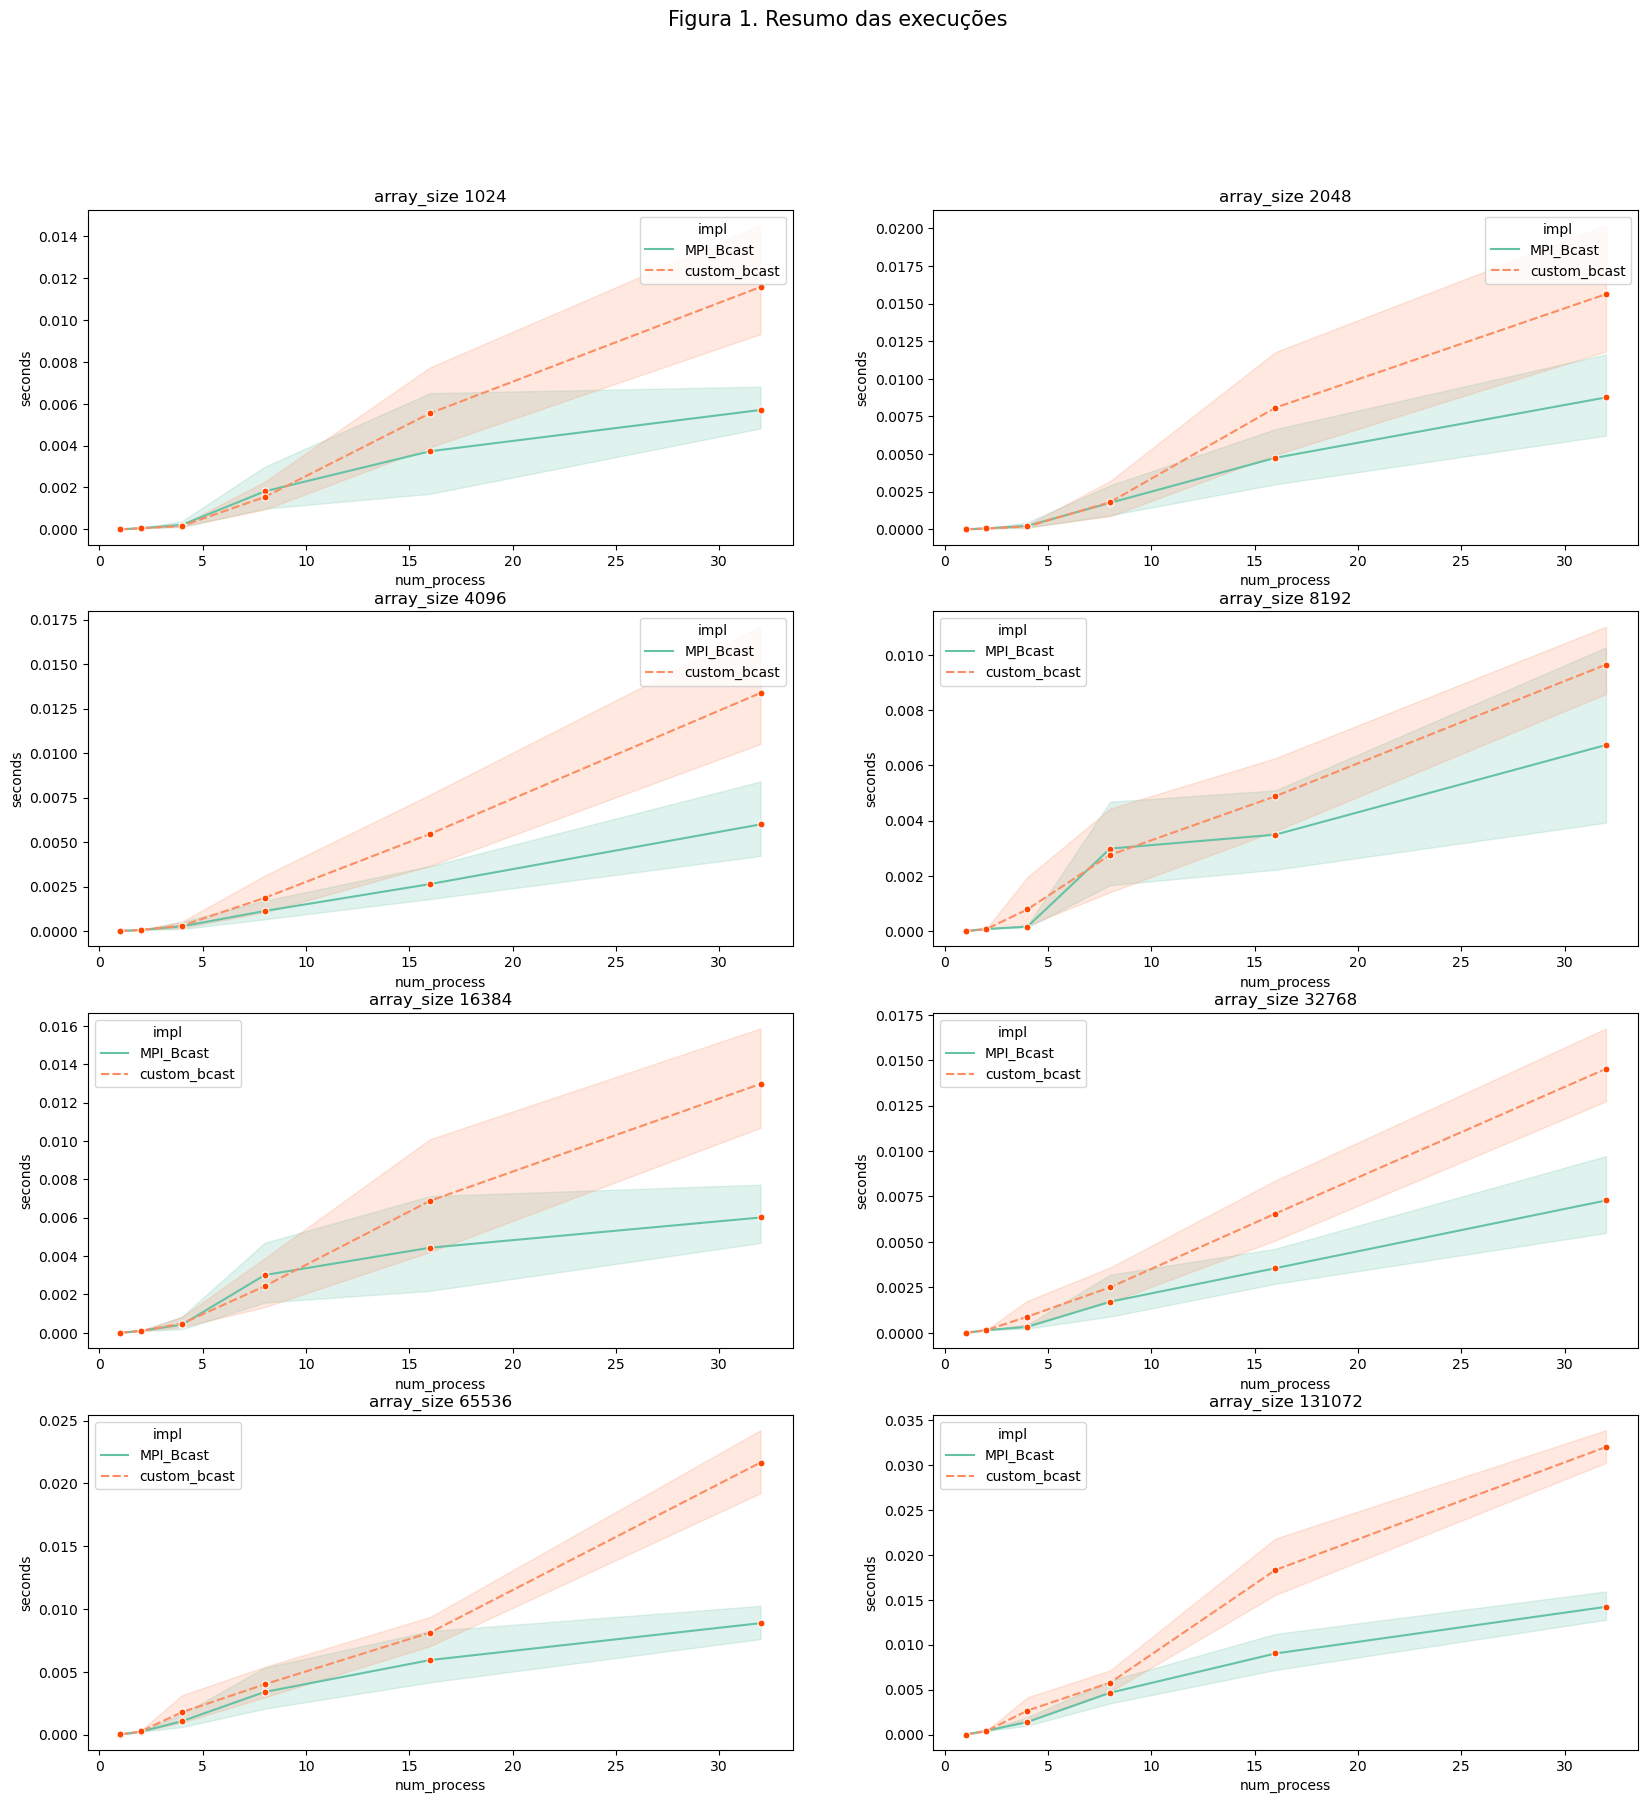

In [26]:
figura_1()

----
# Analisar a variação dos valores obtidos


**Resposta:**


A **Figura 1** resume os valores das duas implementações. A linha referente a implementação ```MPI_bcast``` oferece um baseline de comparação para os resultado implementação ```custom_bcast```.


## num_processes = 1, 2, 4, 8, 16
Para todos os tamanhos de array, pode-se observar que o tempo médio de execução entre as duas implementações fica mais ou menos equivalente dentro dos intervalos de confiança. Embora o valor médio da implementação customizada pareça ser maior do que o valor médio da baseline, a variabilidade das amostras indica que, por si só, não é suficiente para concluir que a implementação customizada seja menos eficiente do que a implementação baseline.

## num_process = 32
Já nessa região, é possível perceber de forma mais clara um descolamento entre os intervalos de confiança, permitindo afirmar que a implementação customizada tem um tempo de execução médio superior à implementação baseline nesse computador específico. Uma possível explicação para isso seria o overhead de tratar a comunicação processo a processo da implementação customizada, o qual começa a se tornar significativo no tempo de execução da tarefa. Além disso, talvez, o fato do processo root chamar o MPI_Send dentro de um loop sequencial também poderia contribuir para um tempo total de execução superior a implementação baseline.



----
# Anexos

### Código de checagem da implementação

In [5]:
import numpy as np
import pandas as pd
import subprocess
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from os.path import exists

CSV_RAW_FILE = 'ep2_diogo_alves_results_raw.csv'
CSV_SUMMARY_FILE = 'ep2_diogo_alves_results_summary.csv'

array_sizes = (2**10, 2**11, 2**12, 2**13, 2**14, 2**15, 2**16, 2**17)
num_processes = (1, 2, 4, 8, 16, 32)
samples_per_evaluation = 30

def cpu_info(): 
  command = "lscpu | grep -Ei '^Cpu\(s\):|thread|core|soquete'"
  subprocess.Popen(command, shell=True).wait()
  return None

def make(debug=False):
  command = 'cd src/ && make clean && make'
  if debug: 
    command += f' debug'
  subprocess.Popen(command, shell=True, stdout=subprocess.DEVNULL).wait()
  return None

def check(array_size, num_process, root):
  cmd = ['mpirun', '-np', str(num_process), '--oversubscribe', './broadcast', '--array_size', str(array_size), '--custom', '--root', str(root)]
  result = False
  with subprocess.Popen(cmd, stdout=subprocess.PIPE, cwd='src') as proc:
    output = str(proc.stdout.read())
    pos_enviados = output.find("enviados")
    pos_inicio_golden = output.find('\\n', pos_enviados + 1) + 2
    pos_fim_golden = output.find('\\n', pos_inicio_golden + 1) - 1
    golden = output[pos_inicio_golden:pos_fim_golden]
    golden_occurrences = output.count(golden)
    result = golden_occurrences == num_process
  return result

def check_all_combinations(array_sizes, num_processes):
  make(debug=True)
  total_evaluations = len(array_sizes) * len(num_processes) * len(num_processes)
  with tqdm(total=total_evaluations) as pbar:
    for array_size in array_sizes:
      for num_process in num_processes:
          for root in range(num_process):
            is_OK = check(array_size, num_process, root)
            if not is_OK:
              print(f'Check failed for array_size={array_size}, num_process={num_process} and root={root}!!!')
              return False
            pbar.update(1)
  print('Check passed for all combinations ✅✅✅')

### Código do experimento

In [2]:
def time_test(array_size, num_process, custom=False):
  cmd = ['mpirun', '-np', str(num_process), '--oversubscribe', './broadcast', '--array_size', str(array_size)]
  if custom:
    cmd.append('--custom')
  
  with subprocess.Popen(cmd, stdout=subprocess.PIPE, cwd='src') as proc:
    seconds = float(proc.stdout.read())
    return seconds

def add_95perc_confidence(row):
  interval = (1.96 * row['std'])/row['count']
  row['95_confidence_interval_min'] = row['mean'] - interval
  row['95_confidence_interval_max'] = row['mean'] + interval
  return row

def experiment(array_sizes, num_processes, samples_per_evaluation):
  make(debug=False)
  results = []

  total_evaluations = samples_per_evaluation * len(array_sizes) * len(num_processes)
  print(f'''
      array_sizes: {array_sizes}
      num_processes: {num_processes}
      samples_per_evaluation: {samples_per_evaluation}
      
      total_baseline_evaluations: {total_evaluations }
      ''')
  with tqdm(total=total_evaluations) as pbar:
    for array_size in array_sizes:
      for num_process in num_processes:
        for _ in range(samples_per_evaluation):
          # Baseline
          seconds = time_test(array_size, num_process, custom=False)
          results.append({'impl': 'MPI_Bcast', 'array_size': array_size, 'num_process': num_process, 'seconds': seconds})
          
          # Custom implementation
          seconds = time_test(array_size, num_process, custom=True)
          results.append({'impl': 'custom_bcast', 'array_size': array_size, 'num_process': num_process, 'seconds': seconds})
          pbar.update(1)

  results = pd.DataFrame(results)
  results_summary = results.groupby(['impl', 'array_size', 'num_process'])['seconds'].describe()[['count', 'mean', 'std']].reset_index()
  results_summary = results_summary.apply(add_95perc_confidence, axis=1)
  results_summary = results_summary.astype({'impl': str, 'array_size': int, 'num_process': int, 'count': int})
  
  results.to_csv(CSV_RAW_FILE, index=False)
  results_summary.to_csv(CSV_SUMMARY_FILE, index=False)
  return (results, results_summary)

def reload_or_run(array_sizes, num_processes, samples_per_evaluation):
  results_found = exists(CSV_RAW_FILE) and exists(CSV_SUMMARY_FILE)
  if results_found:
    print('Results found. Loading data to workspace...')
    results = pd.read_csv(CSV_RAW_FILE)
    results_summary = pd.read_csv(CSV_SUMMARY_FILE)
  else:
    print('Results NOT found. Starting the experiment...')
    results, results_summary = experiment(array_sizes, num_processes, samples_per_evaluation)
  return (results, results_summary)

# Reload or run
results, results_summary = reload_or_run(array_sizes, num_processes, samples_per_evaluation)

Results found. Loading data to workspace...


## Código gerador das figuras

In [1]:
def figura_1():
  fig, ax = plt.subplots(4,2,figsize=(20,20))
  fig.suptitle("Figura 1. Resumo das execuções", fontsize=15)
  for index in range(len(array_sizes)):
    row = index//2
    col = index%2
    selected_array_size = array_sizes[index]
    filtrado = results.loc[results['array_size'] == selected_array_size]
    ax[row][col].title.set_text(f'array_size {selected_array_size}')
    sns.lineplot(data=filtrado, x='num_process', y='seconds', hue='impl', style='impl', marker='o', markerfacecolor='orangered', markersize=5, palette = "Set2", ax=ax[row][col])